In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# https://drive.google.com/file/d/1_Va_Pl0Bg7Qy2b0fRBq2d5h8JXdBj3YO/view?usp=sharing
fileDownloaded = drive.CreateFile({"id":"1_Va_Pl0Bg7Qy2b0fRBq2d5h8JXdBj3YO"})

fileDownloaded.GetContentFile("data.pkl")

In [ ]:
import pickle
dataset = pickle.load(open("data.pkl", "rb"))

In [ ]:
dataset.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_category,review_body_clean
0,US,33605939,RGYFDX8QXKEIR,B007KO2MLO,328837464,Big Maria,Digital_Ebook_Purchase,4,0,0,0,0,Quirky,Elmore Leonard meets the cast of Sierra Madre....,2013-09-09,positive,elmore leonard meets the cast of sierra madre ...
1,US,34058393,R13CBGTMNV9R8Z,B005FLODDE,764276359,The Woman Who Wasn't There: The True Story of ...,Digital_Ebook_Purchase,4,1,2,0,1,The Woman Who Wasn't There,This book was very interesting. It is a true s...,2013-09-09,positive,this book was very interesting it is a true st...
2,US,39601147,R7DRFHC0F71O0,B00EA3L35O,535606445,Mary had A Sleepy Sheep,Digital_Ebook_Purchase,5,0,0,0,0,This Sleepy Sheep rocks!,I had the opportunity to review Mary had a Sle...,2013-09-09,positive,i had the opportunity to review mary had a sle...
3,US,17351407,R27LUKEXU3KBXQ,B00BL3JV50,240053004,Starstruck,Digital_Ebook_Purchase,5,1,1,0,1,Steamy and suspenseful!!!!!,What a great read! I really couldn't put this...,2013-09-09,positive,what a great read i really couldn t put this b...
4,US,10463387,R1VXTPUYMNU687,B00CXU7U80,931529805,The Complete Conan Saga,Digital_Ebook_Purchase,5,1,2,0,0,Barbarians,Barbarians need love too ! Short stories work...,2013-09-09,positive,barbarians need love too short stories work we...


In [ ]:
dataset['helpful_votes'].max()

259

In [ ]:
dataset['verified_purchase'].min()

0

In [ ]:
dataset.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'review_category',
       'review_body_clean'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
review_df=dataset[["review_body_clean","review_category"]]
print(review_df.shape)


(51017, 2)


In [ ]:
#review category based on star ratings
review_df["review_category"].value_counts()

positive    42252
neutral      8765
Name: review_category, dtype: int64

In [ ]:
import nltk

In [ ]:
#sentiment analysis with vader
! pip install vaderSentiment


     |████████████████████████████████| 125 kB 4.4 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
review_df['Vader Sentiment'] = review_df['review_body_clean'].apply(vadersentimentanalysis)
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
review_df['Vader Analysis'] = review_df['Vader Sentiment'].apply(vader_analysis)

In [ ]:
review_df.head()
#vader sentiment ranges from -1 to 1

,review_body_clean,review_category,Vader Sentiment,Vader Analysis
0,elmore leonard meets the cast of sierra madre ...,positive,0.0583,Neutral
1,this book was very interesting it is a true st...,positive,0.5039,Positive
2,i had the opportunity to review mary had a sle...,positive,0.5008,Positive
3,what a great read i really couldn t put this b...,positive,0.9349,Positive
4,barbarians need love too short stories work we...,positive,0.7430,Positive


In [ ]:
vader_counts=review_df['Vader Analysis'].value_counts()
vader_counts

Positive    38982
Neutral      9416
Negative     2619
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f78c54398d0>,
 [Text(-0.8114936309873896, 0.7426157060464738, 'Positive'),
  Text(0.6817151907260458, -0.8632869735686686, 'Neutral'),
  Text(1.332481232971969, -0.21678045063497167, 'Negative')],
 [Text(-0.44263288962948516, 0.4050631123889856, '76.4%'),
  Text(0.3718446494869341, -0.47088380376472827, '18.5%'),
  Text(0.8389696652045731, -0.13649139484424141, '5.1%')])

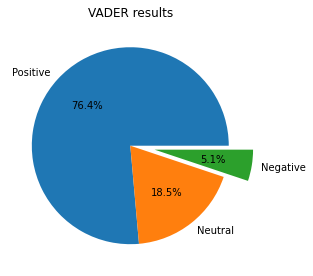

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [ ]:
#concat dataset and review_df
import pandas as pd
data=pd.concat([dataset,review_df['Vader Analysis'],review_df['Vader Sentiment']],axis=1)
data.head()

In [ ]:
pos = data.loc[data['review_category'] == 'positive','review_body_clean']
neu=  data.loc[data['review_category'] == 'neutral','review_body_clean']
neg = data.loc[data['review_category'] == 'negative','review_body_clean']

randomly select 5 reviews with the most neutral sentiment polarity score (zero):

In [ ]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = data.loc[data['Vader Sentiment'] == 0, ['review_body']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

I knew what was going to happen way before it happened but I'm guessing this book is more about fantasy then keeping the pages turning.
I belong to a book club and this one this month's current read.  I couldn't get passed the first 10 pages<br />because there were so many characters that seemed relevant to remember and that was a turn off.
A must for every believer, rather new in Christ or a long time believer. Also a must for every church leader
I got it for my kids to read but they never did so I will read it and give my point a view later
The advice given was also relevant to any other type of promotion, be it business or job searching.  Very relevant to today's social media.


Try multiple regression model to explore the relationship between star rating and vader sentiment score.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
#multiple logisticregression
from sklearn.linear_model import LogisticRegression

y2=data['star_rating']
X2=data[['Vader Sentiment','helpful_votes','verified_purchase']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)
logreg = LogisticRegression(C=1e90).fit(X2_train, y2_train)
print("logreg .coef_: {}".format(logreg .coef_))

logreg .coef_: [[-1.22154584  0.05581377 -0.12741698]
 [-0.76101465  0.03832407  0.06879029]
 [-0.02557802 -0.01225921  0.1194779 ]
 [ 0.80158548 -0.06303555 -0.13114318]
 [ 1.20655303 -0.01884307  0.07029197]]


In [ ]:
#statsmodel packages
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

log_reg = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X2_train, y2_train)
preds = log_reg.predict(X2_test)

X2_train_new = sm.add_constant(X2_train)

logit_model=sm.MNLogit(y2_train,X2_train_new)
logit_model
result=logit_model.fit()
result.summary()
#the reference group is chosen to be "star_rating=1"

# increasing the star rating by one unit will result in an increase by 0.32 units 
#in the log of the ratio between the probability of a neutral review vs. the probability of a negative review

# increasing the star rating by one unit will result in an increase by 0.91 units 
#in the log of the ratio between the probability of a positive review vs. the probability of a negative review

Optimization terminated successfully.
         Current function value: 1.055611
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            star_rating   No. Observations:                38262
Model:                        MNLogit   Df Residuals:                    38246
Method:                           MLE   Df Model:                           12
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                 0.05655
Time:                        00:18:51   Log-Likelihood:                -40390.
converged:                       True   LL-Null:                       -42811.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
    star_rating=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0448      0.095      0.472      0.637      -0.141       0.231
Vader Sentiment       0.4608      0.056      8.299      0.000       0.352       0.570
helpful_votes        -0.0175      0.004     -4.259      0.000      -0.026      -0.009
verified_purchase     0.1932      0.102      1.888      0.059      -0.007       0.394
-------------------------------------------------------------------------------------
    star_rating=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6311      0.085      7.391      0.000       0.464       0.798
Vader Sentiment       1.1965      0.051     23.265      0.000       1.096       1.297
helpful_votes        -0.0681      0.007     -9.156      0.000      -0.083      -0.054
verified_purchase     0.2452      0.091      2.706      0.007       0.068       0.423
-------------------------------------------------------------------------------------
    star_rating=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3049      0.079     16.484      0.000       1.150       1.460
Vader Sentiment       2.0234      0.050     40.230      0.000       1.925       2.122
helpful_votes        -0.1189      0.008    -14.973      0.000      -0.134      -0.103
verified_purchase    -0.0051      0.084     -0.061      0.952      -0.169       0.159
-------------------------------------------------------------------------------------
    star_rating=5       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7747      0.076     23.199      0.000       1.625       1.925
Vader Sentiment       2.4283      0.048     50.944      0.000       2.335       2.522
helpful_votes        -0.0746      0.005    -14.403      0.000      -0.085      -0.064
verified_purchase     0.1962      0.081      2.410      0.016       0.037       0.356
=====================================================================================
"""

In [ ]:
#create confusion matrix
confusion_matrix(y2_test, preds)

array([[  86,    0,    0,    0,  383],
       [  53,    0,    0,    0,  473],
       [  51,    0,    0,    0, 1171],
       [  58,    0,    0,    0, 2827],
       [ 114,    0,    0,    0, 7539]])

In [ ]:
print('Accuracy Score:', metrics.accuracy_score(y2_test, preds))  

Accuracy Score: 0.5978047824382595


In [ ]:
# polarity score(vader sentiment) by star rating
score_table = data.pivot_table(index='star_rating', aggfunc = np.mean)
score_table

,Vader Sentiment,helpful_votes,total_votes,verified_purchase,vine
star_rating,,,,,
1,-0.023384,3.822581,7.322581,0.834816,0.000000
2,0.172558,2.091249,3.487131,0.857745,0.000000
3,0.455258,0.997308,1.500828,0.860248,0.000000
4,0.658857,0.659959,0.856071,0.818980,0.000085
5,0.717767,0.875475,1.087701,0.838553,0.000000


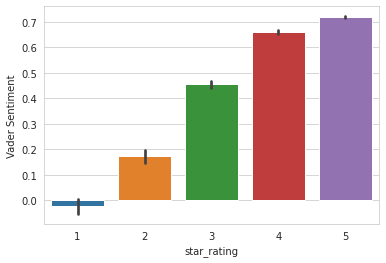

In [ ]:
sns.barplot(data = data
            ,x = 'star_rating'
            ,y = 'Vader Sentiment'
            )

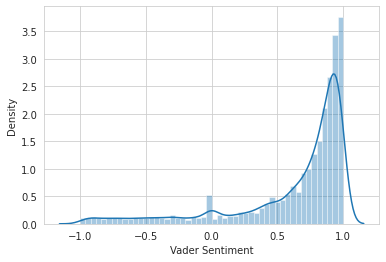

In [ ]:
import seaborn as sn
sn.distplot(data['Vader Sentiment'])

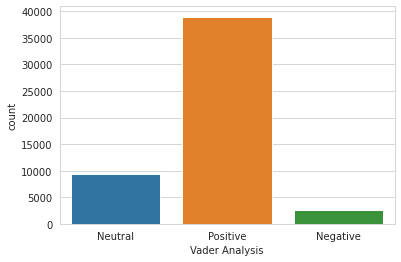

In [ ]:
#Plot the Polarity rating count graph:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='Vader Analysis',data=data)

In [ ]:
#Create classification report
class_report=classification_report(y2_test, preds)
print(class_report)

              precision    recall  f1-score   support

           1       0.24      0.18      0.21       469
           2       0.00      0.00      0.00       526
           3       0.00      0.00      0.00      1222
           4       0.00      0.00      0.00      2885
           5       0.61      0.99      0.75      7653

    accuracy                           0.60     12755
   macro avg       0.17      0.23      0.19     12755
weighted avg       0.37      0.60      0.46     12755



Sentiment analysis by Textblob

In [ ]:
#sentiment analysis with Textblob
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
   # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
review_df['textblob_subjectivity'] = review_df['review_body_clean'].apply(getSubjectivity)
review_df['textblob_polarity'] = review_df['review_body_clean'].apply(getPolarity)
review_df['textblob_sentiment'] = review_df['textblob_polarity'].apply(analysis)

In [ ]:
review_df.head()

,review_body_clean,review_category,Vader Sentiment,Vader Analysis,textblob_subjectivity,textblob_polarity,textblob_sentiment
0,elmore leonard meets the cast of sierra madre ...,positive,0.0583,Neutral,1.000000,0.000000,Neutral
1,this book was very interesting it is a true st...,positive,0.5039,Positive,0.671429,0.157143,Positive
2,i had the opportunity to review mary had a sle...,positive,0.5008,Positive,0.680000,-0.188750,Negative
3,what a great read i really couldn t put this b...,positive,0.9349,Positive,0.606481,0.340741,Positive
4,barbarians need love too short stories work we...,positive,0.7430,Positive,0.300000,0.166667,Positive


In [ ]:
textblob_counts=review_df['textblob_sentiment'].value_counts()
textblob_counts

Positive    45774
Negative     4192
Neutral      1051
Name: textblob_sentiment, dtype: int64

([<matplotlib.patches.Wedge at 0x7f78c53a3e90>,
 [Text(-1.0431649076314928, 0.349008560763456, 'Positive'),
  Text(1.0184089046491525, -0.41574427588520546, 'Negative'),
  Text(1.3471736365948435, -0.08731089773805481, 'Neutral')],
 [Text(-0.5689990405262688, 0.19036830587097597, '89.7%'),
  Text(0.5554957661722649, -0.22676960502829385, '8.2%'),
  Text(0.8482204378560125, -0.05497352820544191, '2.1%')])

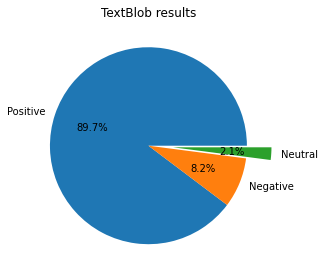

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(textblob_counts.values, labels = textblob_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [ ]:
#transform confusion matrix into array
#the matrix is stored in a vaiable called confmtrx
confmtrx = np.array(confusion_matrix(y2_test, preds))
#Create DataFrame from confmtrx array 
pd.DataFrame(confmtrx, index=[''],
             columns=[''])

Sentiment analysis by Textblob

In [ ]:
#concat dataset and review_df
import pandas as pd
data=pd.concat([data,review_df['textblob_subjectivity'],review_df['textblob_polarity'],review_df['textblob_sentiment']],axis=1)
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_category,review_body_clean,Vader Analysis,Vader Sentiment,textblob_subjectivity,textblob_polarity,textblob_sentiment
0,US,33605939,RGYFDX8QXKEIR,B007KO2MLO,328837464,Big Maria,Digital_Ebook_Purchase,4,0,0,0,0,Quirky,Elmore Leonard meets the cast of Sierra Madre....,2013-09-09,positive,elmore leonard meets the cast of sierra madre ...,Neutral,0.0583,1.000000,0.000000,Neutral
1,US,34058393,R13CBGTMNV9R8Z,B005FLODDE,764276359,The Woman Who Wasn't There: The True Story of ...,Digital_Ebook_Purchase,4,1,2,0,1,The Woman Who Wasn't There,This book was very interesting. It is a true s...,2013-09-09,positive,this book was very interesting it is a true st...,Positive,0.5039,0.671429,0.157143,Positive
2,US,39601147,R7DRFHC0F71O0,B00EA3L35O,535606445,Mary had A Sleepy Sheep,Digital_Ebook_Purchase,5,0,0,0,0,This Sleepy Sheep rocks!,I had the opportunity to review Mary had a Sle...,2013-09-09,positive,i had the opportunity to review mary had a sle...,Positive,0.5008,0.680000,-0.188750,Negative
3,US,17351407,R27LUKEXU3KBXQ,B00BL3JV50,240053004,Starstruck,Digital_Ebook_Purchase,5,1,1,0,1,Steamy and suspenseful!!!!!,What a great read! I really couldn't put this...,2013-09-09,positive,what a great read i really couldn t put this b...,Positive,0.9349,0.606481,0.340741,Positive
4,US,10463387,R1VXTPUYMNU687,B00CXU7U80,931529805,The Complete Conan Saga,Digital_Ebook_Purchase,5,1,2,0,0,Barbarians,Barbarians need love too ! Short stories work...,2013-09-09,positive,barbarians need love too short stories work we...,Positive,0.7430,0.300000,0.166667,Positive


In [ ]:
#multiple logisticregression
from sklearn.linear_model import LogisticRegression

y3=data['star_rating']
X3=data[['textblob_polarity','textblob_subjectivity','helpful_votes','verified_purchase']]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)
logreg = LogisticRegression(C=1e90).fit(X3_train, y3_train)
print("logreg .coef_: {}".format(logreg .coef_))

logreg .coef_: [[-3.9715187  -0.49589114  0.05471767 -0.10472749]
 [-2.24955123  0.11050405  0.03616643  0.14621051]
 [ 0.29281782  0.02434205 -0.01887532  0.16964426]
 [ 2.46910733  0.01148315 -0.06244742 -0.17215021]
 [ 3.45914478  0.34956189 -0.00956136 -0.03897707]]


In [ ]:
#statsmodel packages
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

log_reg = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X3_train, y3_train)
preds = log_reg.predict(X3_test)

X3_train_new = sm.add_constant(X3_train)

logit_model=sm.MNLogit(y3_train,X3_train_new)
logit_model
result=logit_model.fit()
result.summary()
#the reference group is chosen to be "star_rating=1"

# increasing the star rating by one unit will result in an increase by 0.32 units 
#in the log of the ratio between the probability of a neutral review vs. the probability of a negative review

Optimization terminated successfully.
         Current function value: 1.048399
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            star_rating   No. Observations:                38262
Model:                        MNLogit   Df Residuals:                    38242
Method:                           MLE   Df Model:                           16
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                 0.06300
Time:                        00:52:25   Log-Likelihood:                -40114.
converged:                       True   LL-Null:                       -42811.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
        star_rating=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3498      0.144     -2.430      0.015      -0.632      -0.068
textblob_polarity         1.7170      0.167     10.302      0.000       1.390       2.044
textblob_subjectivity     0.6651      0.209      3.186      0.001       0.256       1.074
helpful_votes            -0.0189      0.004     -4.449      0.000      -0.027      -0.011
verified_purchase         0.2508      0.103      2.438      0.015       0.049       0.452
-----------------------------------------------------------------------------------------
        star_rating=3       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2155      0.128      1.688      0.092      -0.035       0.466
textblob_polarity         4.3244      0.163     26.536      0.000       4.005       4.644
textblob_subjectivity     0.5656      0.190      2.984      0.003       0.194       0.937
helpful_votes            -0.0739      0.008     -9.499      0.000      -0.089      -0.059
verified_purchase         0.2864      0.091      3.156      0.002       0.108       0.464
-----------------------------------------------------------------------------------------
        star_rating=4       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.9808      0.118      8.339      0.000       0.750       1.211
textblob_polarity         6.5073      0.157     41.359      0.000       6.199       6.816
textblob_subjectivity     0.5323      0.178      2.991      0.003       0.184       0.881
helpful_votes            -0.1175      0.008    -14.867      0.000      -0.133      -0.102
verified_purchase        -0.0658      0.083     -0.793      0.428      -0.228       0.097
-----------------------------------------------------------------------------------------
        star_rating=5       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.3191      0.114     11.617      0.000       1.097       1.542
textblob_polarity         7.4809      0.152     49.078      0.000       7.182       7.780
textblob_subjectivity     0.8785      0.171      5.151      0.000       0.544       1.213
helpful_votes            -0.0643      0.005    -13.243      0.000      -0.074      -0.055
verified_purchase         0.0720      0.081      0.893      0.372      -0.086       0.230
=========================================================================================
"""

In [ ]:
print('Accuracy Score:', metrics.accuracy_score(y2_test, preds)) 

Accuracy Score: 0.6010976087808703


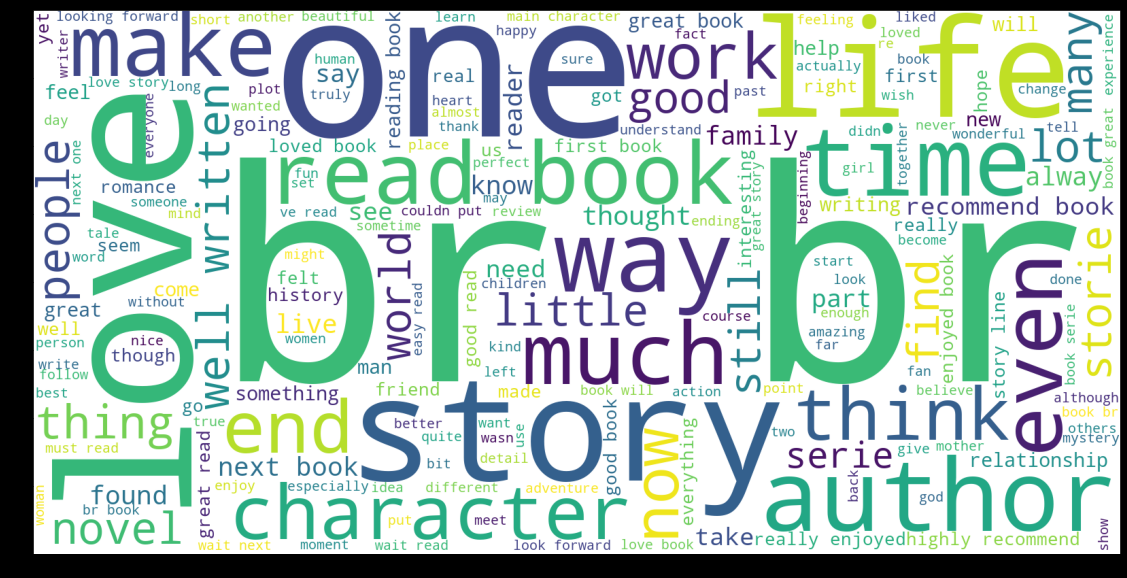

In [ ]:
#see Popular words in Review, I didn't remove "br" so please look at Xingchen's part for the wordcloud pic
from wordcloud import WordCloud
wordcloud= WordCloud(background_color="white",width=1600,height=800).generate(' '.join(pos))
plt.figure(figsize=(10,10),facecolor='k')
plt.imshow(wordcloud)

In [ ]:
#some codes I didn't use
wordcloud = WordCloud(stopwords='stopwords.txt').generate(' '.join(autores_atuais['Ementa']))
# Create a CSV file to store a set of stopwords

import csv # Import the csv module to work with csv files
with open('data/stop_words.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(stop_words)

with open('data/stop_words.csv', 'r') as f:
    stop_words = f.read().strip().split(",")
print(stopwords)